In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from time import time
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, accuracy_score, f1_score, roc_auc_score, classification_report
from astropy.table import Table
from sklearn.metrics import roc_auc_score

In [15]:
df = pd.read_csv('student_data.csv')

In [16]:
df

school sex  age address famsize Pstatus  Medu  Fedu      Mjob      Fjob  \
0       GP   F   18       U     GT3       A     4     4   at_home   teacher   
1       GP   F   17       U     GT3       T     1     1   at_home     other   
2       GP   F   15       U     LE3       T     1     1   at_home     other   
3       GP   F   15       U     GT3       T     4     2    health  services   
4       GP   F   16       U     GT3       T     3     3     other     other   
..     ...  ..  ...     ...     ...     ...   ...   ...       ...       ...   
390     MS   M   20       U     LE3       A     2     2  services  services   
391     MS   M   17       U     LE3       T     3     1  services  services   
392     MS   M   21       R     GT3       T     1     1     other     other   
393     MS   M   18       R     LE3       T     3     2  services     other   
394     MS   M   19       U     LE3       T     1     1     other   at_home   

     ... internet romantic  famrel  freetime  goout Dalc Walc health absences  \
0    ...       no       no       4         3      4    1    1      3        6   
1    ...      yes       no       5         3      3    1    1      3        4   
2    ...      yes       no       4         3      2    2    3      3       10   
3    ...      yes      yes       3         2      2    1    1      5        2   
4    ...       no       no       4         3      2    1    2      5        4   
..   ...      ...      ...     ...       ...    ...  ...  ...    ...      ...   
390  ...       no       no       5         5      4    4    5      4       11   
391  ...      yes       no       2         4      5    3    4      2        3   
392  ...       no       no       5         5      3    3    3      3        3   
393  ...      yes       no       4         4      1    3    4      5        0   
394  ...      yes       no       3         2      3    3    3      5        5   

    passed  
0       no  
1       no  
2      yes  
3      yes  
4      yes  
..     ...  
390     no  
391    yes  
392     no  
393    yes  
394     no  

[395 rows x 31 columns]

In [17]:
# mapping strings to numeric values:
def numerical_data():
    df['school'] = df['school'].map({'GP': 0, 'MS': 1})
    df['sex'] = df['sex'].map({'M': 0, 'F': 1})
    df['address'] = df['address'].map({'U': 0, 'R': 1})
    df['famsize'] = df['famsize'].map({'LE3': 0, 'GT3': 1})
    df['Pstatus'] = df['Pstatus'].map({'T': 0, 'A': 1})
    df['Mjob'] = df['Mjob'].map({'teacher': 0, 'health': 1, 'services': 2, 'at_home': 3, 'other': 4})
    df['Fjob'] = df['Fjob'].map({'teacher': 0, 'health': 1, 'services': 2, 'at_home': 3, 'other': 4})
    df['reason'] = df['reason'].map({'home': 0, 'reputation': 1, 'course': 2, 'other': 3})
    df['guardian'] = df['guardian'].map({'mother': 0, 'father': 1, 'other': 2})
    df['schoolsup'] = df['schoolsup'].map({'no': 0, 'yes': 1})
    df['famsup'] = df['famsup'].map({'no': 0, 'yes': 1})
    df['paid'] = df['paid'].map({'no': 0, 'yes': 1})
    df['activities'] = df['activities'].map({'no': 0, 'yes': 1})
    df['nursery'] = df['nursery'].map({'no': 0, 'yes': 1})
    df['higher'] = df['higher'].map({'no': 0, 'yes': 1})
    df['internet'] = df['internet'].map({'no': 0, 'yes': 1})
    df['romantic'] = df['romantic'].map({'no': 0, 'yes' : 1})
    df['passed'] = df['passed'].map({'no': 0, 'yes': 1})
    # reorder dataframe columns :
    col = df['passed']
    del df['passed']
    df['passed'] = col

In [20]:
# feature scaling will allow the algorithm to converge faster, large data will have same scal
def feature_scaling(df):
    for i in df:
        col = df[i]
        # let's choose columns that have large values
        if(np.max(col)>6):
            Max = max(col)
            Min = min(col)
            mean = np.mean(col)
            col  = (col-mean)/(Max)
            df[i] = col
        elif(np.max(col)<6):
            col = (col-np.min(col))
            col /= np.max(col)
            df[i] = col

In [18]:
# All values in numerical after calling numerical_data() function
numerical_data()
df

school  sex  age  address  famsize  Pstatus  Medu  Fedu  Mjob  Fjob  ...  \
0         0    1   18        0        1        1     4     4     3     0  ...   
1         0    1   17        0        1        0     1     1     3     4  ...   
2         0    1   15        0        0        0     1     1     3     4  ...   
3         0    1   15        0        1        0     4     2     1     2  ...   
4         0    1   16        0        1        0     3     3     4     4  ...   
..      ...  ...  ...      ...      ...      ...   ...   ...   ...   ...  ...   
390       1    0   20        0        0        1     2     2     2     2  ...   
391       1    0   17        0        0        0     3     1     2     2  ...   
392       1    0   21        1        1        0     1     1     4     4  ...   
393       1    0   18        1        0        0     3     2     2     4  ...   
394       1    0   19        0        0        0     1     1     4     3  ...   

     internet  romantic  famrel  freetime  goout  Dalc  Walc  health  \
0           0         0       4         3      4     1     1       3   
1           1         0       5         3      3     1     1       3   
2           1         0       4         3      2     2     3       3   
3           1         1       3         2      2     1     1       5   
4           0         0       4         3      2     1     2       5   
..        ...       ...     ...       ...    ...   ...   ...     ...   
390         0         0       5         5      4     4     5       4   
391         1         0       2         4      5     3     4       2   
392         0         0       5         5      3     3     3       3   
393         1         0       4         4      1     3     4       5   
394         1         0       3         2      3     3     3       5   

     absences  passed  
0           6       0  
1           4       0  
2          10       1  
3           2       1  
4           4       1  
..        ...     ...  
390        11       0  
391         3       1  
392         3       0  
393         0       1  
394         5       0  

[395 rows x 31 columns]

In [19]:
# Let's scal our features
feature_scaling(df)

# Now we are ready for models training
df

school  sex       age  address  famsize  Pstatus  Medu  Fedu  Mjob  Fjob  \
0       0.0  1.0  0.059264      0.0      1.0      1.0  1.00  1.00  0.75  0.00   
1       0.0  1.0  0.013809      0.0      1.0      0.0  0.25  0.25  0.75  1.00   
2       0.0  1.0 -0.077100      0.0      0.0      0.0  0.25  0.25  0.75  1.00   
3       0.0  1.0 -0.077100      0.0      1.0      0.0  1.00  0.50  0.25  0.50   
4       0.0  1.0 -0.031646      0.0      1.0      0.0  0.75  0.75  1.00  1.00   
..      ...  ...       ...      ...      ...      ...   ...   ...   ...   ...   
390     1.0  0.0  0.150173      0.0      0.0      1.0  0.50  0.50  0.50  0.50   
391     1.0  0.0  0.013809      0.0      0.0      0.0  0.75  0.25  0.50  0.50   
392     1.0  0.0  0.195627      1.0      1.0      0.0  0.25  0.25  1.00  1.00   
393     1.0  0.0  0.059264      1.0      0.0      0.0  0.75  0.50  0.50  1.00   
394     1.0  0.0  0.104718      0.0      0.0      0.0  0.25  0.25  1.00  0.75   

     ...  internet  romantic  famrel  freetime  goout  Dalc  Walc  health  \
0    ...       0.0       0.0    0.75      0.50   0.75  0.00  0.00    0.50   
1    ...       1.0       0.0    1.00      0.50   0.50  0.00  0.00    0.50   
2    ...       1.0       0.0    0.75      0.50   0.25  0.25  0.50    0.50   
3    ...       1.0       1.0    0.50      0.25   0.25  0.00  0.00    1.00   
4    ...       0.0       0.0    0.75      0.50   0.25  0.00  0.25    1.00   
..   ...       ...       ...     ...       ...    ...   ...   ...     ...   
390  ...       0.0       0.0    1.00      1.00   0.75  0.75  1.00    0.75   
391  ...       1.0       0.0    0.25      0.75   1.00  0.50  0.75    0.25   
392  ...       0.0       0.0    1.00      1.00   0.50  0.50  0.50    0.50   
393  ...       1.0       0.0    0.75      0.75   0.00  0.50  0.75    1.00   
394  ...       1.0       0.0    0.50      0.25   0.50  0.50  0.50    1.00   

     absences  passed  
0    0.003882     0.0  
1   -0.022785     0.0  
2    0.057215     1.0  
3   -0.049451     1.0  
4   -0.022785     1.0  
..        ...     ...  
390  0.070549     0.0  
391 -0.036118     1.0  
392 -0.036118     0.0  
393 -0.076118     1.0  
394 -0.009451     0.0  

[395 rows x 31 columns]

In [21]:
df.shape

(395, 31)

In [22]:
df.dropna().shape # their is no null value "fortunately:)"

(395, 31)

In [23]:
df.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'passed'],
      dtype='object')

In [24]:
features=['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences']

In [26]:
#plot of student status
dfv['passed'].value_counts()

yes    265
no     130
Name: passed, dtype: int64

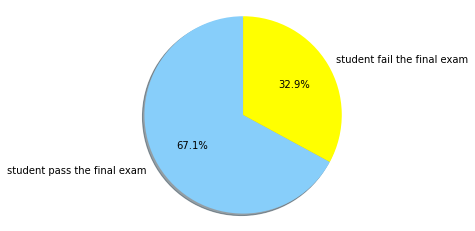

In [27]:
labels = 'student pass the final exam ', 'student fail the final exam'
sizes = [265, 130]
colors=['lightskyblue','yellow']
fig1, ax1 = plt.subplots()
ax1.pie(sizes,  labels=labels, autopct='%1.1f%%',colors=colors,
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

Likely most of student passed the final exam ,our target is to decrease the number of failure as max as possible.

Text(0.5, 1.0, 'Correlation Heatmap')

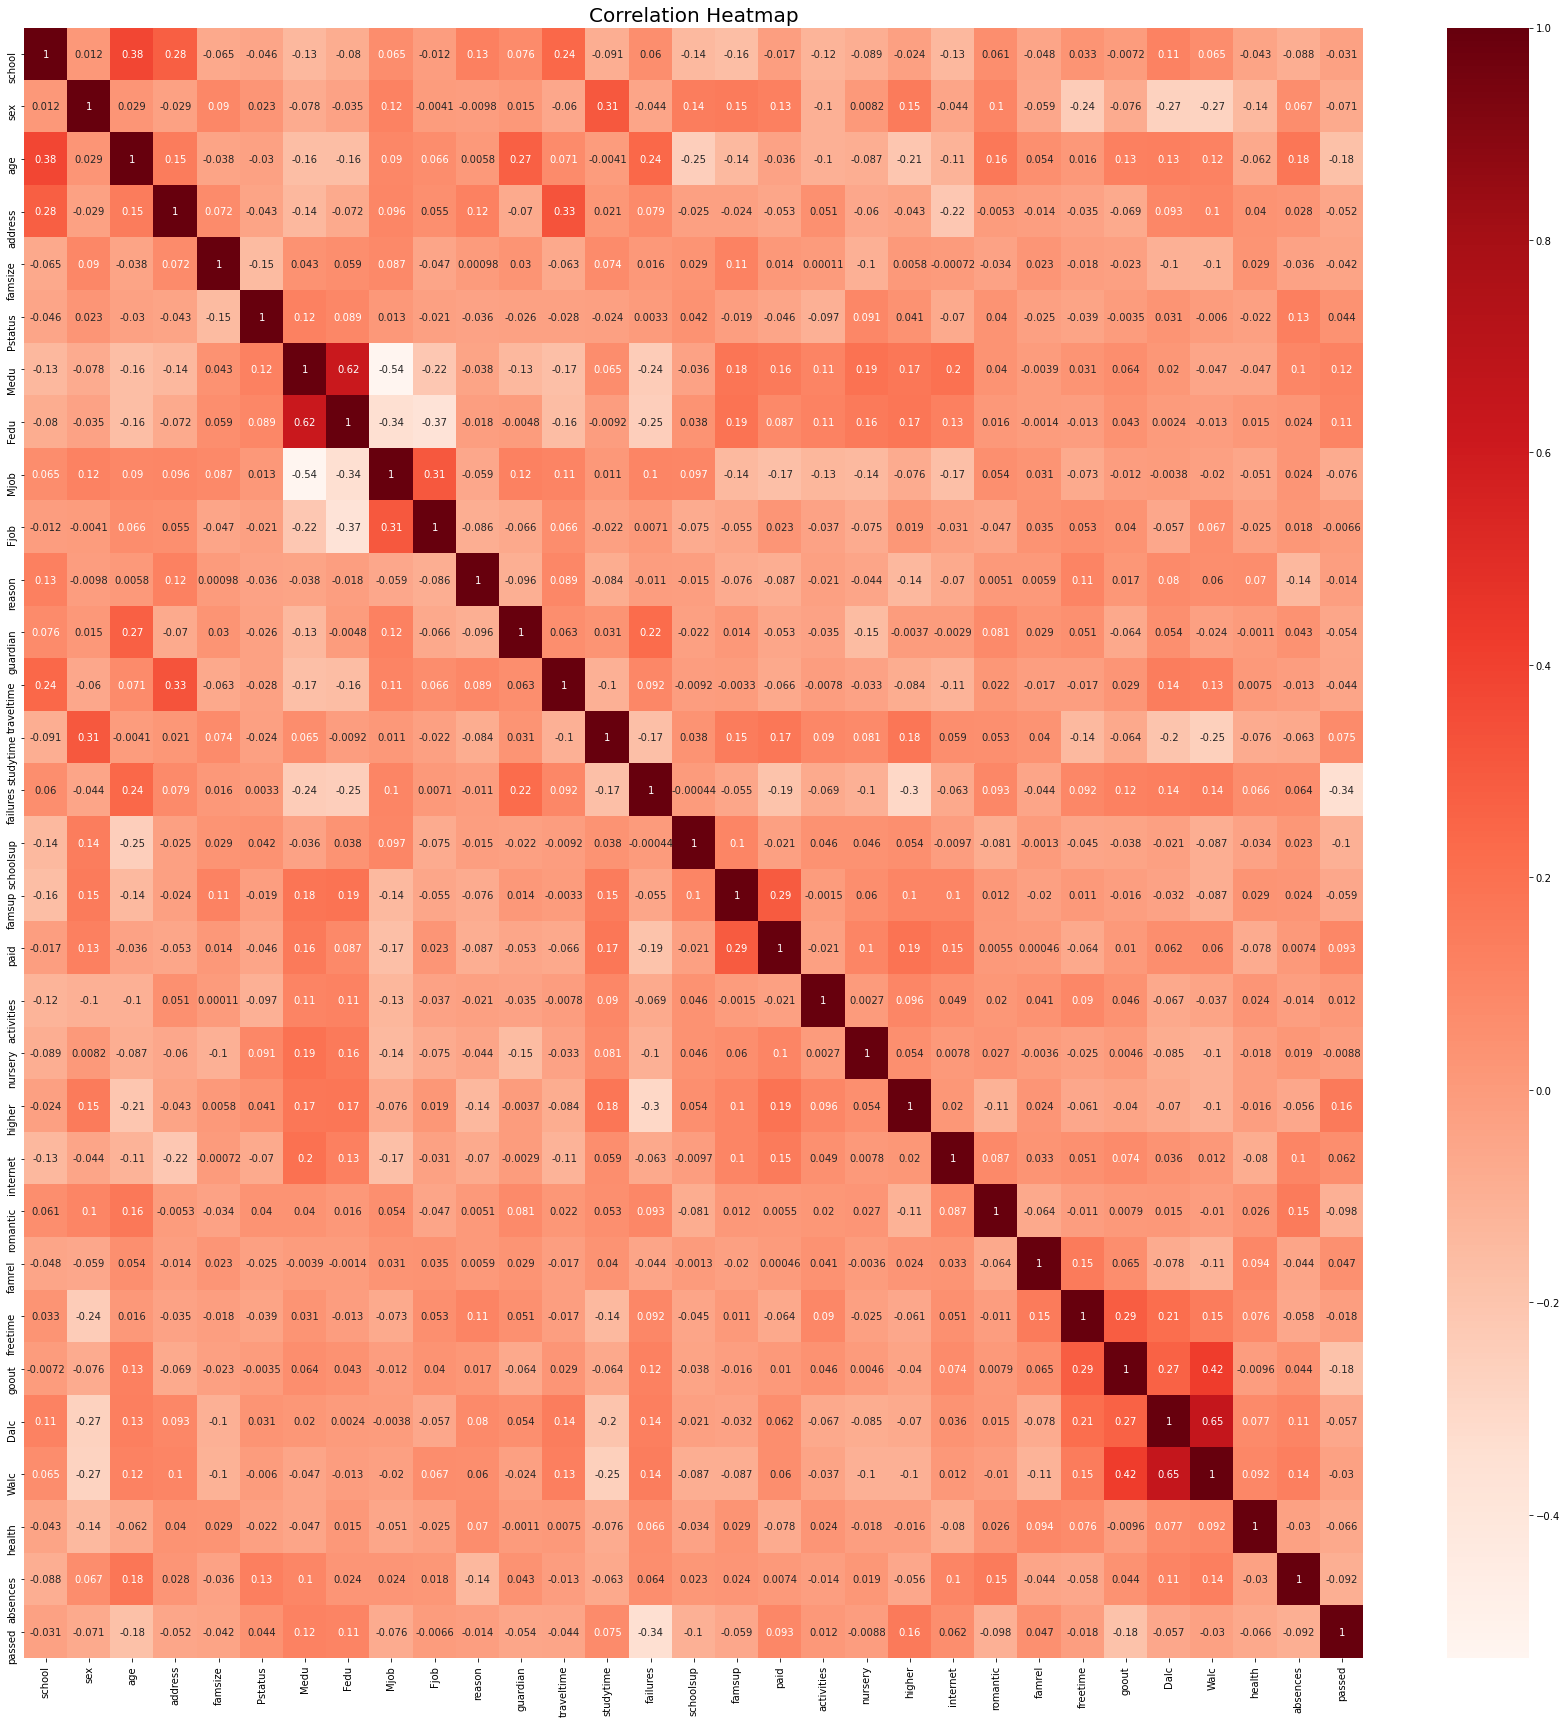

In [29]:
# see correlation between variables through a correlation heatmap
corr = df.corr()
plt.figure(figsize=(30,30))
sns.heatmap(corr, annot=True, cmap="Reds")
plt.title('Correlation Heatmap', fontsize=20)

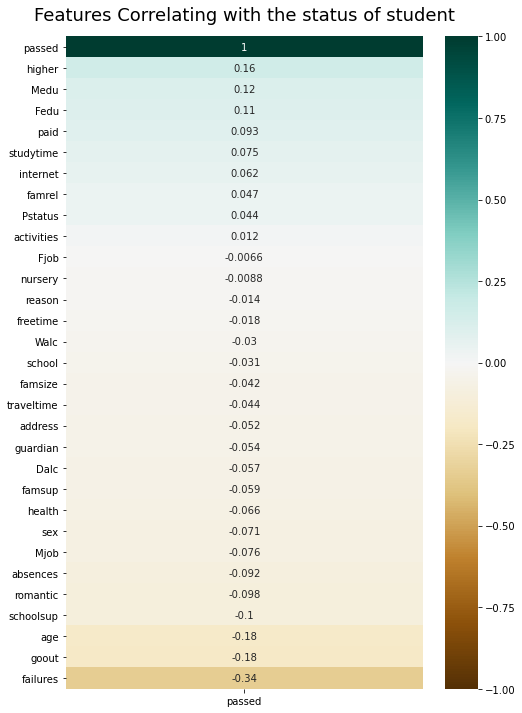

In [30]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(df.corr()[['passed']].sort_values(by='passed', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with the status of student', fontdict={'fontsize':18}, pad=16);

In [31]:
df["goout"].unique()

array([0.75, 0.5 , 0.25, 0.  , 1.  ])

Text(0.5, 0, 'Student status')

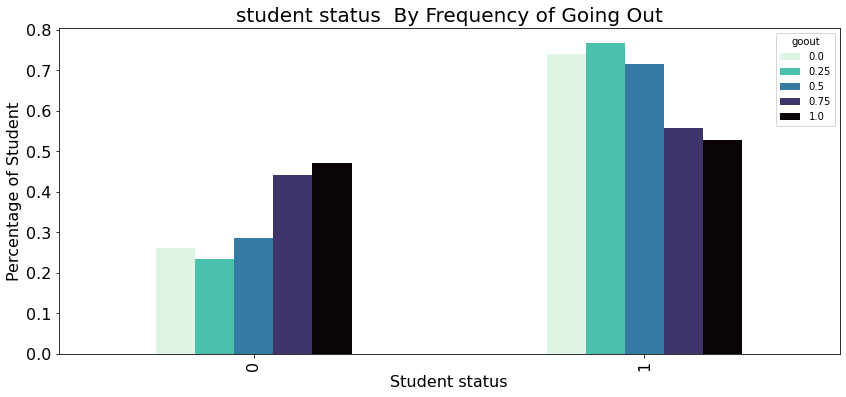

In [32]:
# going out
perc = (lambda col: col/col.sum())
index = [0,1]
out_tab = pd.crosstab(index=df.passed, columns=df.goout)
out_perc = out_tab.apply(perc).reindex(index)
out_perc.plot.bar(colormap="mako_r", fontsize=16, figsize=(14,6))
plt.title('student status  By Frequency of Going Out', fontsize=20)
plt.ylabel('Percentage of Student', fontsize=16)
plt.xlabel('Student status', fontsize=16)

 it seems that most of people who passed the exam had less hour of going out ,as a conclusion we should limit the hour of going out.

<Figure size 432x288 with 0 Axes>

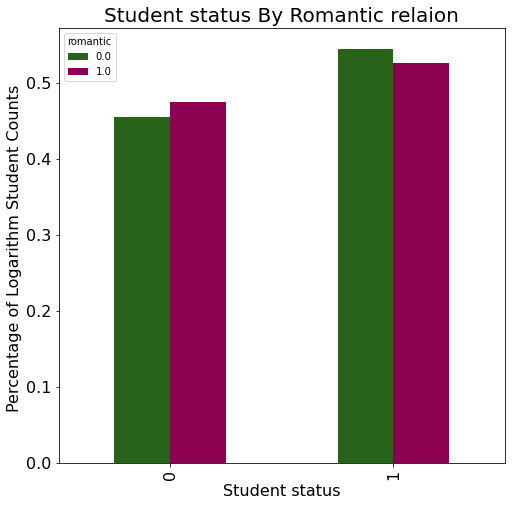

In [33]:
# romantic status
romance_tab1 = pd.crosstab(index=df.passed, columns=df.romantic)
romance_tab = np.log(romance_tab1)
romance_perc = romance_tab.apply(perc).reindex(index)
plt.figure()
romance_perc.plot.bar(colormap="PiYG_r", fontsize=16, figsize=(8,8))
plt.title('Student status By Romantic relaion', fontsize=20)
plt.ylabel('Percentage of Logarithm Student Counts ', fontsize=16)
plt.xlabel('Student status', fontsize=16)
plt.show()
# 0 in romantic mean no romantic relation

Most of people whow passed the exam had no romantic relation ,sow no relation could be a good choice for better performance.

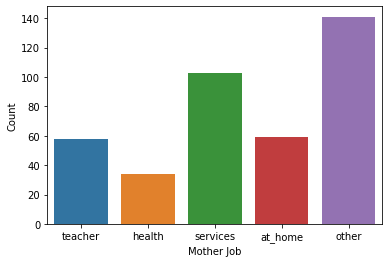

In [34]:
# 1) mother job 
# Mjob distribution
f, fx = plt.subplots()
figure = sns.countplot(x = 'Mjob', data=dfv, order=['teacher','health','services','at_home','other'])
fx = fx.set(ylabel="Count", xlabel="Mother Job")
figure.grid(False)

<Figure size 432x288 with 0 Axes>

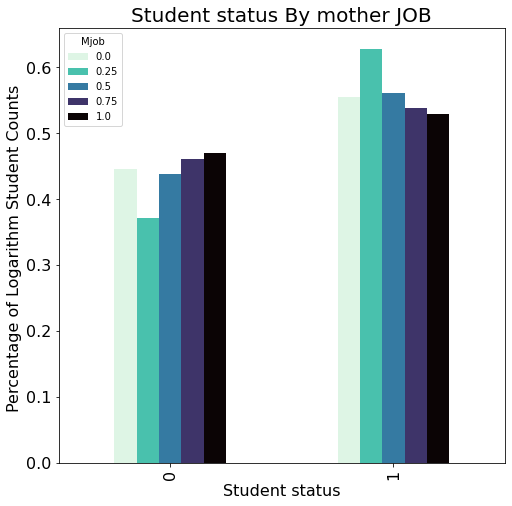

In [35]:
mjob_tab1 = pd.crosstab(index=df.passed, columns=df.Mjob)
mjob_tab = np.log(mjob_tab1)
mjob_perc = mjob_tab.apply(perc).reindex(index)
plt.figure()
mjob_perc.plot.bar(colormap="mako_r", fontsize=16, figsize=(8,8))
plt.title('Student status By mother JOB', fontsize=20)
plt.ylabel('Percentage of Logarithm Student Counts ', fontsize=16)
plt.xlabel('Student status', fontsize=16)
plt.show()
#'teacher': 0, 'health': 1, 'services': 2, 'at_home': 3, 'other': 4

/var/folders/gy/sfq3f6894rd1v__jp0ggg92c0000gn/T/ipykernel_80771/3018233835.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  good['good_student_mother_education'] = good.Medu
/var/folders/gy/sfq3f6894rd1v__jp0ggg92c0000gn/T/ipykernel_80771/3018233835.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  poor['poor_student_mother_education'] = poor.Medu


Text(0.5, 0, 'Mother Education Level')

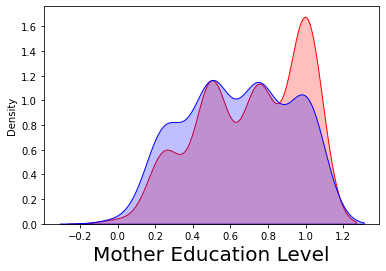

In [36]:
#Mother education:
good = df.loc[df.passed==1]
poor=df.loc[df.passed==0]
good['good_student_mother_education'] = good.Medu
poor['poor_student_mother_education'] = poor.Medu
plt.figure(figsize=(6,4))
p=sns.kdeplot(good['good_student_mother_education'], shade=True, color="r")#good_student in red
p=sns.kdeplot(poor['poor_student_mother_education'], shade=True, color="b")#poor_student in blue
plt.xlabel('Mother Education Level', fontsize=20)

Mother's education had good impact in student status.If we look into the second heatmap previousely it seems that Mother's education is more impactfful than father's education

Text(0, 0.5, 'Percentage of Student')

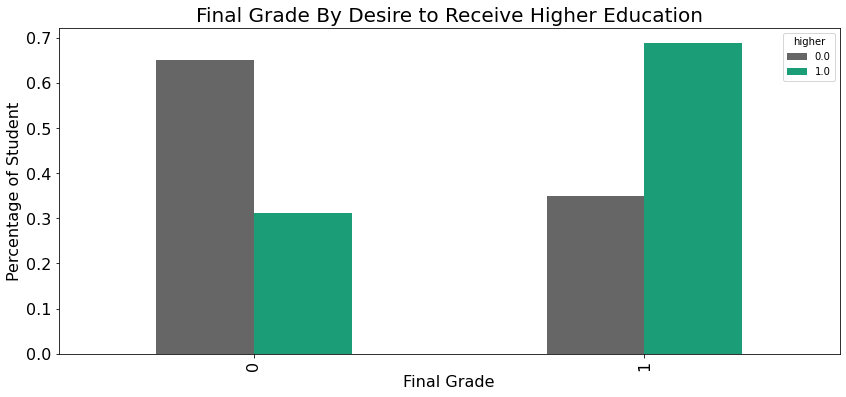

In [37]:
higher_tab = pd.crosstab(index=df.passed, columns=df.higher)
higher_perc = higher_tab.apply(perc).reindex(index)
higher_perc.plot.bar(colormap="Dark2_r", figsize=(14,6), fontsize=16)
plt.title('Final Grade By Desire to Receive Higher Education', fontsize=20)
plt.xlabel('Final Grade', fontsize=16)
plt.ylabel('Percentage of Student', fontsize=16)

Most of people who passed the exam want to take heigher education sow it could be a good idea to encourage your kids or students to take heigher education.

Text(0, 0.5, 'Percentage of Student')

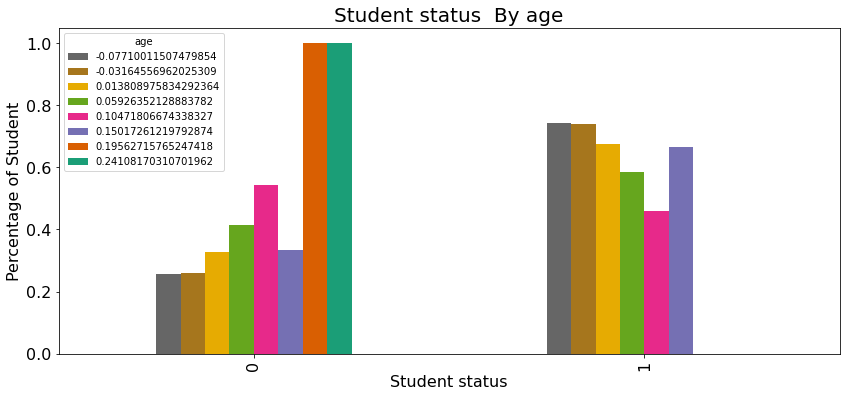

In [38]:
#impact of age
higher_tab = pd.crosstab(index=df.passed, columns=df.age)
higher_perc = higher_tab.apply(perc).reindex(index)
higher_perc.plot.bar(colormap="Dark2_r", figsize=(14,6), fontsize=16)
plt.title('Student status  By age', fontsize=20)
plt.xlabel('Student status', fontsize=16)
plt.ylabel('Percentage of Student', fontsize=16)

Age also play an importent role in student sucess, most of people who passed the exam had early age 15, and most people who failed the exam had an age of 22 .As a conclusion it could be better to go to school in early age.

Text(0, 0.5, 'Percentage of Student')

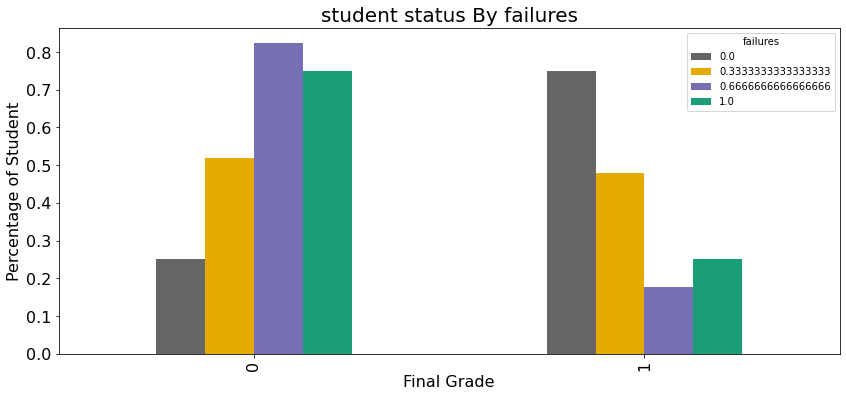

In [39]:
fail_tab = pd.crosstab(index=df.passed, columns=df.failures)
fail_perc = fail_tab.apply(perc).reindex(index)
fail_perc.plot.bar(colormap="Dark2_r", figsize=(14,6), fontsize=16)
plt.title('student status By failures', fontsize=20)
plt.xlabel('Final Grade', fontsize=16)
plt.ylabel('Percentage of Student', fontsize=16)

Text(0.5, 1.0, 'Address Distribution')

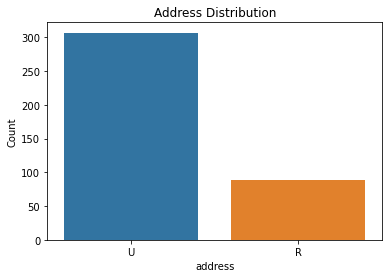

In [40]:
#first let's see the destribution of students who live in urban or rural area
f, fx = plt.subplots()
figure = sns.countplot(x = 'address', data=dfv, order=['U','R'])
fx = fx.set(ylabel="Count", xlabel="address")
figure.grid(False)
plt.title('Address Distribution')

Text(0.5, 0, 'Student status')

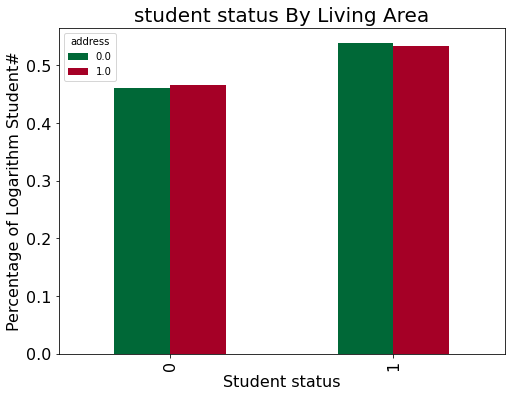

In [41]:
ad_tab1 = pd.crosstab(index=df.passed, columns=df.address)
ad_tab = np.log(ad_tab1)
ad_perc = ad_tab.apply(perc).reindex(index)
ad_perc.plot.bar(colormap="RdYlGn_r", fontsize=16, figsize=(8,6))
plt.title('student status By Living Area', fontsize=20)
plt.ylabel('Percentage of Logarithm Student#', fontsize=16)
plt.xlabel('Student status', fontsize=16)

Area doesn't had an impact on student performance even people with good results live in contry side

Text(0, 0.5, 'Percentage of Student')

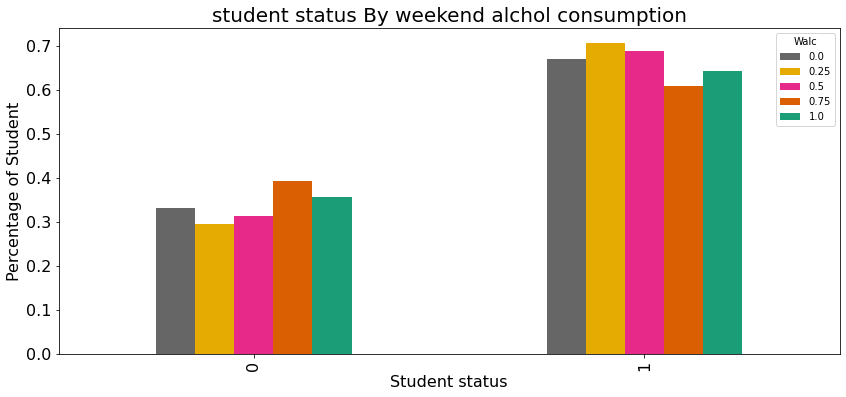

In [42]:
#impact of weekend alcohol consumption in student performance
alc_tab = pd.crosstab(index=df.passed, columns=df.Walc)
alc_perc = alc_tab.apply(perc).reindex(index)
alc_perc.plot.bar(colormap="Dark2_r", figsize=(14,6), fontsize=16)
plt.title('student status By weekend alchol consumption', fontsize=20)
plt.xlabel('Student status', fontsize=16)
plt.ylabel('Percentage of Student', fontsize=16)

/var/folders/gy/sfq3f6894rd1v__jp0ggg92c0000gn/T/ipykernel_80771/2044405682.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  good['good_alcohol_usage']=good.Walc
/var/folders/gy/sfq3f6894rd1v__jp0ggg92c0000gn/T/ipykernel_80771/2044405682.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  poor['poor_alcohol_usage']=poor.Walc


Text(0.5, 0, 'Level of Alcohol Consumption')

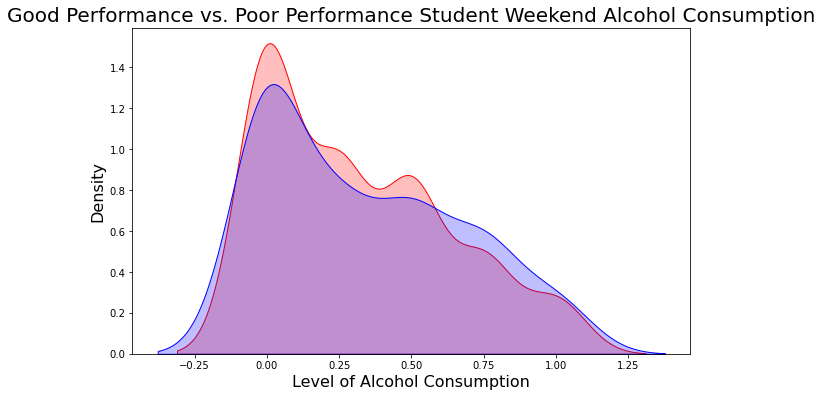

In [43]:

# weekend alcohol consumption
# create good student dataframe
good = df.loc[df.passed == 1]
good['good_alcohol_usage']=good.Walc
# create poor student dataframe
poor = df.loc[df.passed == 0]
poor['poor_alcohol_usage']=poor.Walc
plt.figure(figsize=(10,6))
p1=sns.kdeplot(good['good_alcohol_usage'], shade=True, color="r")
p1=sns.kdeplot(poor['poor_alcohol_usage'], shade=True, color="b")
plt.title('Good Performance vs. Poor Performance Student Weekend Alcohol Consumption', fontsize=20)
plt.ylabel('Density', fontsize=16)
plt.xlabel('Level of Alcohol Consumption', fontsize=16)

For weekely alchool consumption it doesn't have an strong impact on student performance .Even people with low consumption had low grad.

Text(0, 0.5, 'Percentage of Student')

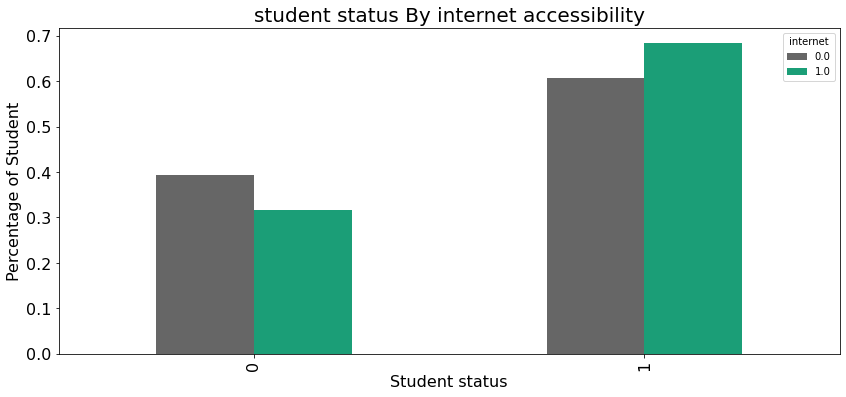

In [44]:
alc_tab = pd.crosstab(index=df.passed, columns=df.internet)
alc_perc = alc_tab.apply(perc).reindex(index)
alc_perc.plot.bar(colormap="Dark2_r", figsize=(14,6), fontsize=16)
plt.title('student status By internet accessibility', fontsize=20)
plt.xlabel('Student status', fontsize=16)
plt.ylabel('Percentage of Student', fontsize=16)

Most of people who passed the exam had the accessibility to internet ,sow we should provide a fair materials's education

Text(0, 0.5, 'Percentage of Student')

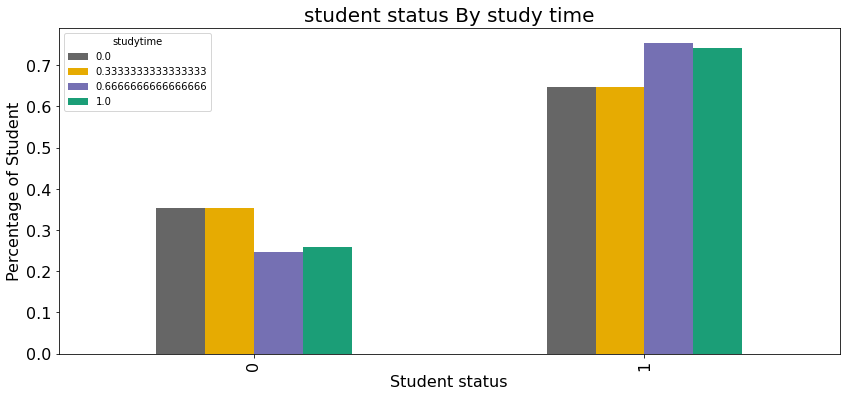

In [46]:
stu_tab = pd.crosstab(index=df.passed, columns=df.studytime)
stu_perc = stu_tab.apply(perc).reindex(index)
stu_perc.plot.bar(colormap="Dark2_r", figsize=(14,6), fontsize=16)
plt.title('student status By study time', fontsize=20)
plt.xlabel('Student status', fontsize=16)
plt.ylabel('Percentage of Student', fontsize=16)

Text(0, 0.5, 'Percentage of Student')

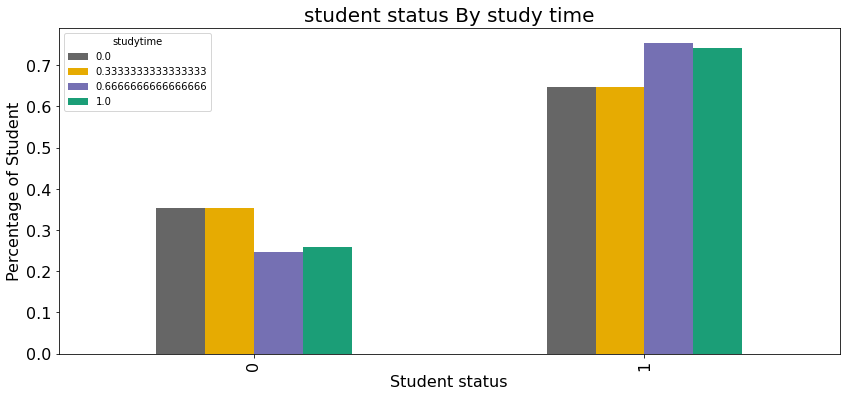

In [48]:
stu_tab = pd.crosstab(index=df.passed, columns=df.studytime)
stu_perc = stu_tab.apply(perc).reindex(index)
stu_perc.plot.bar(colormap="Dark2_r", figsize=(14,6), fontsize=16)
plt.title('student status By study time', fontsize=20)
plt.xlabel('Student status', fontsize=16)
plt.ylabel('Percentage of Student', fontsize=16)

Most of people who passed the exam study 5-10 hours weekely

Text(0, 0.5, 'Percentage of Student')

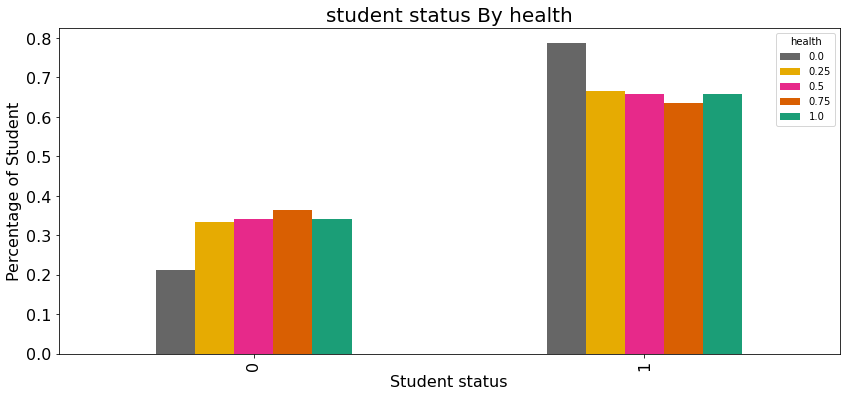

In [50]:
he_tab = pd.crosstab(index=df.passed, columns=df.health)
he_perc = he_tab.apply(perc).reindex(index)
he_perc.plot.bar(colormap="Dark2_r", figsize=(14,6), fontsize=16)
plt.title('student status By health', fontsize=20)
plt.xlabel('Student status', fontsize=16)
plt.ylabel('Percentage of Student', fontsize=16)

most of student who fails the exam don't have a good health

3) General conclusion :¶
Summary:
After dealing with the most relevent features ,the valedictorian of an exellents conditions for heigh academic potentials is likely to have this profile:

1.Does not go out with friend frequently

2.Is not in romantic relation

3.Parents receive higher education specialy woman

4.Have strong desire to receive higher education

5.Mother is a health care professional

6.father is a teacher

7.No absences to classes

8.have access to internet

9.study more than 10 hours a week

10.Is healthy

In [51]:
# split data train 70 % and test 30 %

data = df.to_numpy()
n = data.shape[1]
x = data[:,0:n-1]
y = data[:,n-1]
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=0)

# Once our data is split, we can forget about x_test and y_test until we define our model.
#x_train and y_train are the samples we will use to train the model

In [52]:
# let's create a model and train it 

logisticRegr = LogisticRegression(C=1)

In [53]:
#and now let's do the training

logisticRegr.fit(x_train,y_train)

LogisticRegression(C=1)

### The model is now trained and ready to make predictions :)

In [55]:
y_pred=logisticRegr.predict(x_test)
y_pred

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0.,
       1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
       1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1.])

In order to evaluate our model , we will first calculate the accuracy of the model , visualize the confusion matrix, and then plot the ROC curve.

In [57]:
#let's have a look at the accuracy of the model

Sctest=logisticRegr.score(x_test,y_test)
Sctrain=logisticRegr.score(x_train,y_train)

print('#Accuracy test is: ',Sctest)
print('#Accuracy train is: ',Sctrain)


f1 = f1_score(y_test, y_pred, average='macro')

print('\n#f1 score is: ',f1)

#Accuracy test is:  0.6386554621848739
#Accuracy train is:  0.7463768115942029

#f1 score is:  0.5533734834598935


### We got two values of the accuracy, one obtained with the training set and other with the test set.

It might be a good idea to compare the two, as a situation where the training set accuracy is much higher might indicate overfitting. The test set accuracy is more relevant for evaluating the performance on unseen data since it’s not biased.

In [58]:
#let's have a look at the accuracy of the model

Sctest=logisticRegr.score(x_test,y_test)
Sctrain=logisticRegr.score(x_train,y_train)

print('Accuracy test is: ',Sctest)
print('Accuracy train is: ',Sctrain)

Accuracy test is:  0.6386554621848739
Accuracy train is:  0.7463768115942029


In [59]:
#now, we can get the confusion matrix with confusion_matrix():

confusion_matrix(y_test, y_pred)

array([[12, 38],
       [ 5, 64]])

<AxesSubplot:>

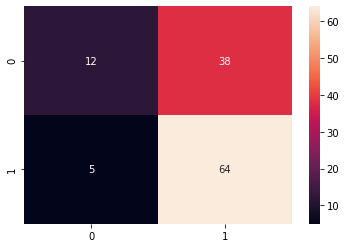

In [60]:
#let's visualize the confusion matrix:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm,annot=True)

We can now get the report on classification as a string or dictionary with classification_report():

In [61]:
#import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.71      0.24      0.36        50
         1.0       0.63      0.93      0.75        69

    accuracy                           0.64       119
   macro avg       0.67      0.58      0.55       119
weighted avg       0.66      0.64      0.58       119



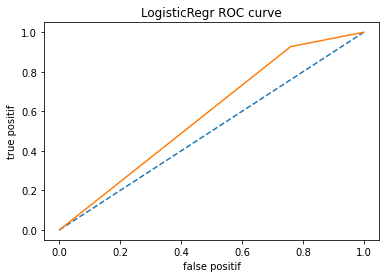

In [62]:
#ploting the roc_curve

fpositif, tpositif, thresholds = roc_curve(y_test, y_pred)
plt.plot([0,1],[0,1],'--')
plt.plot(fpositif,tpositif, label='LogisticRegr')
plt.xlabel('false positif')
plt.ylabel('true positif')
plt.title('LogisticRegr ROC curve')
p=plt.show()

### we still need to improve our model in order to be more accurate!
### 3-improving model accuracy
Now, we are going to use random state to randomly split the data into training & test set.

The algorithm gives different accuracy each time we change the data split. And we know that if we built a good model, then the accuracy should not vary too much depending on the random state. ...But still, we can train the model for some iterations and instead of using the values "0" and "1" for the random state, we will choose the value "optimal_state" that maximizes the accuracy and the F1 score for the iterations given.




*Accuracy is: 80.67226890756302
*f1 score is:  0.7408389357068459


 *the ROC curve: 


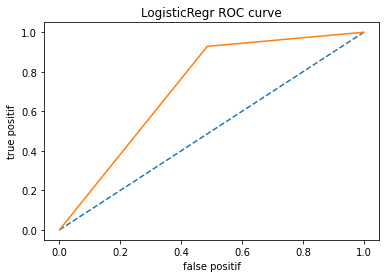

 *the confusion matrix 


<AxesSubplot:>

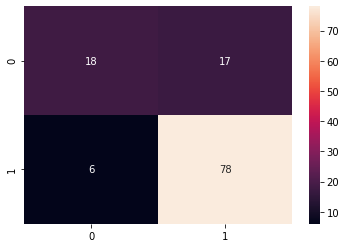

In [63]:
max_iteration = 0
maxF1 = 0
maxAccuracy = 0
optimal_state = 0
import random
for k in range(max_iteration):
    print ('Iteration :'+str(k)+', Current accuracy: '+str(maxAccuracy)+ ', Current f1 : '+str(maxF1), end="\r")
    split_state = np.random.randint(1,100000000)-1
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=split_state)
    logisticRegr = LogisticRegression(C=1)
    logisticRegr.fit(x_train,y_train)
    y_pred=logisticRegr.predict(x_test)
    f1 = f1_score(y_test, y_pred, average='macro')
    accuracy = accuracy_score(y_test, y_pred)*100
    
    if (accuracy>maxAccuracy and f1>maxF1):
        maxF1 = f1 
        maxAccuracy = accuracy
        optimal_state = split_state
    
   
optimal_state = 85491961
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=optimal_state)
logisticRegr = LogisticRegression(C=1)
logisticRegr.fit(x_train,y_train)
y_pred=logisticRegr.predict(x_test)
f1 = f1_score(y_test, y_pred, average='macro')
accuracy = accuracy_score(y_test, y_pred)*100
print('\n\n\n*Accuracy is: '+str(accuracy)+'\n*f1 score is: ',f1)

yt_lg,yp_lg = y_test,y_pred
#ploting the roc_curve

print ( '\n\n *the ROC curve: ')

fpositif, tpositif, thresholds = roc_curve(y_test, y_pred)
plt.plot([0,1],[0,1],'--')
plt.plot(fpositif,tpositif, label='LogisticRegr')
plt.xlabel('false positif')
plt.ylabel('true positif')
plt.title('LogisticRegr ROC curve')
p=plt.show()


#visualizig the confusion matrix:

print (' *the confusion matrix ')

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm,annot=True)

### conclusion¶
we notice that we went from an accuracy of 64% to 80.67%. and we got a higher value for F1 score as well ; from 0.55 to 0.74 .

### k-nearest neighbors

In [64]:
#define data
y=df.passed
target=["passed"]
x = df.drop(target,axis = 1 )

Method 1: (by visualisation)
-In tis method we are going to choose best K base on visualisation:




*Accuracy is: 78.15126050420169
*f1 score is:  0.7102996254681648
random_state is  71027464


 *the ROC curve: 


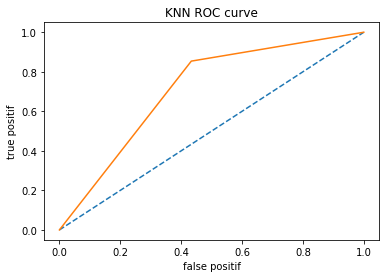

 *the confusion matrix 


<AxesSubplot:>

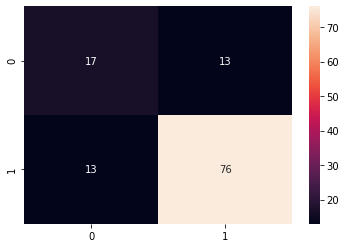

In [65]:
max_iteration = 0
maxF1 = 0
maxAccuracy = 0
optimal_state = 0
for k in range(max_iteration):
    print ('Iteration :'+str(k)+', Current accuracy: '+str(maxAccuracy)+ ', Current f1 : '+str(maxF1), end="\r")
    split_state = np.random.randint(1,100000000)-1
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=split_state)
    KNN = KNeighborsClassifier()
    KNN.fit(x_train,y_train)
    y_pred=KNN.predict(x_test)
    f1 = f1_score(y_test, y_pred, average='macro')
    accuracy = accuracy_score(y_test, y_pred)*100
    
    if (accuracy>maxAccuracy and f1>maxF1):
        maxF1 = f1 
        maxAccuracy = accuracy
        optimal_state = split_state
    
optimal_state = 71027464

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=optimal_state)
KNN= KNeighborsClassifier()
KNN.fit(x_train,y_train)
y_pred=KNN.predict(x_test)
f1 = f1_score(y_test, y_pred, average='macro')
accuracy = accuracy_score(y_test, y_pred)*100
print('\n\n\n*Accuracy is: '+str(accuracy)+'\n*f1 score is: ',f1)

print ('random_state is ',optimal_state)


#ploting the roc_curve

print ( '\n\n *the ROC curve: ')

fpositif, tpositif, thresholds = roc_curve(y_test, y_pred)
plt.plot([0,1],[0,1],'--')
plt.plot(fpositif,tpositif, label='knn')
plt.xlabel('false positif')
plt.ylabel('true positif')
plt.title('KNN ROC curve')
p=plt.show()

yt_knn,yp_knn= y_test,y_pred
#visualizig the confusion matrix:

print (' *the confusion matrix ')

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm,annot=True)

As we can see the best random state are 71027464 corresponding to an accuracy of 78% wish is a good accuracy

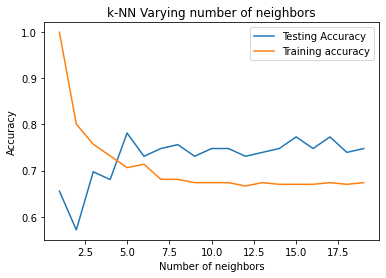

In [66]:
#Setup arrays to store training and test accuracies
neighbors= np.arange(1,20)
train_accuracy =np.empty(19)
test_accuracy = np.empty(19)

for i,k in enumerate(neighbors):
    #Setup a knn classifier with k neighbors
    knn = KNeighborsClassifier(n_neighbors=k)
    
    #Fit the model
    knn.fit(x_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(x_train, y_train)
    
    #Compute accuracy on the test set
    test_accuracy[i] = knn.score(x_test, y_test) 
    
#  Plotting the curv
plt.title('k-NN Varying number of neighbors')
plt.plot(neighbors, test_accuracy, label='Testing Accuracy')
plt.plot(neighbors, train_accuracy, label='Training accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.show()

In our case study we had a binary classification sow it could be better to choose an odd value of K. By looking into the curv We can observe above that we get maximum testing accuracy for k=5 .In next step let's confirm if 5 was a good choice by using gridsearchCV.


Method 2: (using GridSearchCV)

###### 1) best k for training:

In [67]:
#In case of classifier like knn the parameter to be tuned is n_neighbors 
param_grid = {'n_neighbors':np.arange(1,20)}
knn = KNeighborsClassifier()
knn_cv= GridSearchCV(knn,param_grid,cv=5)
knn_cv.fit(x_train,y_train)
#best score\n",
knn_cv.best_score_

0.6449350649350649

In [68]:
knn_cv.best_params_

{'n_neighbors': 19}

######  2) best k for testing:

In [69]:

param_grid = {'n_neighbors':np.arange(1,20)}
knn = KNeighborsClassifier()
knn_cv= GridSearchCV(knn,param_grid,cv=5)
knn_cv.fit(x_test,y_test)
#best score\n",
knn_cv.best_score_

0.7728260869565217

In [70]:
knn_cv.best_params_

{'n_neighbors': 13}

#### 2) best k for all the dataset:

In [71]:
param_grid = {'n_neighbors':np.arange(1,20)}
knn = KNeighborsClassifier()
knn_cv= GridSearchCV(knn,param_grid,cv=5)
knn_cv.fit(x,y)
#best score\n",
knn_cv.best_score_

0.6734177215189873

In [72]:

knn_cv.best_params_

{'n_neighbors': 7}

#### To conclude the best k for:

1)training is :19

2)testing is :13

3)all the dataset:7


Method 3:
In this method we are going to fixe the value of k to k= 17 and search for Best metric(distance) based on time and acc .

In [73]:
params = {"n_neighbors":[7,19] , "metric":["euclidean", "manhattan", "chebyshev"]}
acc = {}

for m in params["metric"]:
    acc[m] = []
    for k in params["n_neighbors"]:
        print("Model_{} metric: {}, n_neighbors: {}".format(i, m, k))
        i += 1
        t = time()
        knn = KNeighborsClassifier(n_neighbors=k, metric=m)
        knn.fit(x_train,y_train)
        pred = knn.predict(x_test)
        print("Time: ", time() - t)
        acc[m].append(accuracy_score(y_test, y_pred))
        print("Acc: ", acc[m][-1])

Model_18 metric: euclidean, n_neighbors: 7
Time:  0.016985177993774414
Acc:  0.7815126050420168
Model_19 metric: euclidean, n_neighbors: 19
Time:  0.011178970336914062
Acc:  0.7815126050420168
Model_20 metric: manhattan, n_neighbors: 7
Time:  0.008871316909790039
Acc:  0.7815126050420168
Model_21 metric: manhattan, n_neighbors: 19
Time:  0.0077970027923583984
Acc:  0.7815126050420168
Model_22 metric: chebyshev, n_neighbors: 7
Time:  0.006271839141845703
Acc:  0.7815126050420168
Model_23 metric: chebyshev, n_neighbors: 19
Time:  0.005970954895019531
Acc:  0.7815126050420168



As We can see the metrics or distances gives the same accuracy but time is different,the optimal_time for k=7 is 0.019012451171875 . This choice gives heigh Acc=78% with less time consuming compared to other distances the wining distance is chebyshev

third step:
In this method we are going to commbine knn hyperparameters tuning (second step) and the optimal random state(first step) to get high accuracy

B)Final model implementation
As we discover in privious section the best parameters to implement knn algorithme are:

K=7
metric=chebyshev-distance

In [74]:
max_iteration = 0
maxF1 = 0
maxAccuracy = 0
optimal_state = 0
f1 = 0
accuracy = 0
True60 = False
for k in range(max_iteration):
    print ('Iteration :'+str(k)+', Current accuracy: '+str(maxAccuracy)+ ', Current f1 : '+str(maxF1), end="\r")
    split_state = np.random.randint(1,100000000)-1
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=split_state)
    KNN = KNeighborsClassifier(n_neighbors=7,metric='chebyshev')
    KNN.fit(x_train,y_train)
    y_pred=KNN.predict(x_test)
    f1 = f1_score(y_test, y_pred, average='macro')
    accuracy = accuracy_score(y_test, y_pred)*100
    
    if accuracy>maxAccuracy and f1>=0.5:
        maxF1 = f1 
        maxAccuracy = accuracy
        optimal_state = split_state
        if maxAccuracy>79:
            break
    
optimal_state = 29300362         
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=optimal_state)
KNN_f= KNeighborsClassifier(n_neighbors=7,metric='chebyshev')
KNN_f.fit(x_train,y_train)
y_pred=KNN_f.predict(x_test)
f1 = f1_score(y_test, y_pred, average='macro')
accuracy = accuracy_score(y_test, y_pred)*100
print('\n\n\n*Accuracy is: '+str(accuracy)+'\n*f1 score is: ',f1)

print ('random_state is ',optimal_state)

yt_knn,yp_knn= y_test,y_pred




*Accuracy is: 79.83193277310924
*f1 score is:  0.5423076923076924
random_state is  29300362


-As we can see if we combine the best knn parameters and optimal state the acquracy improve from 78% to 79% It's clear that hyperparameters_tuning increase the result but most impactfull parameters are random_state

forth step:
To evaluate our model we are going to

use heatmap (matrice de confusion )
use the precision recall and F1 score for each class
plotting the roc curve

##### 1)Confusion matrix

Accuracy is:  0.7983193277310925


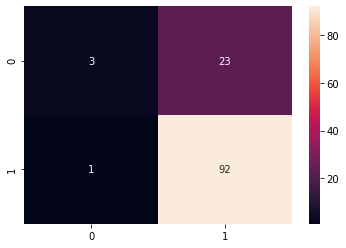

In [75]:
ac = accuracy_score(yt_knn,yp_knn)
print('Accuracy is: ',ac)
cm= confusion_matrix(yt_knn,yp_knn)
sns.heatmap(cm,annot=True)
yt_knn,yp_knn = y_test,y_pred

#### 2)classification_report

In [76]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.75      0.12      0.20        26
         1.0       0.80      0.99      0.88        93

    accuracy                           0.80       119
   macro avg       0.78      0.55      0.54       119
weighted avg       0.79      0.80      0.74       119



 the ROC curve: 


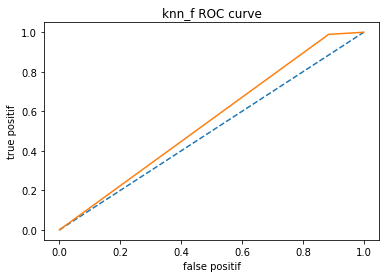

In [77]:
#ploting the roc_curve

print ( ' the ROC curve: ')

fpositif, tpositif, thresholds = roc_curve(y_test, y_pred)
plt.plot([0,1],[0,1],'--')
plt.plot(fpositif,tpositif, label='final knn model')
plt.xlabel('false positif')
plt.ylabel('true positif')
plt.title('knn_f ROC curve')
p=plt.show()

#### 4) Conclusion :
The main goal of this part was to understand the impact of knn_hyper_parameters_tuning. As a first step we implement a model that tune the optimal random_state without specifying knn_parameters, after we evaluate the model and we get an accuracy of 78%,next we search to increase this accuracy by fitting the model with the best parameters for that we search at first for the best k using the gridsearchCV and after we fix the best value of k and search for The best metrics. Finally, we got the best model with k=17 and metrics=chebychev and we got a better accuracy of 79% as we can see the impact of hyper_parameters wasn't so strong the importent parameter is the randome_state.

#### Support vector machine

In [78]:
# Show results of every model

def showResults(accuracy, trainingTime, y_pred,model):
    
    print('------------------------------------------------Results :',model,'-------------------------------------------------')
    confusionMatrix = confusion_matrix(y_test, y_pred)
    print('\n The ROC curve is :\n')
    fig, _ = plt.subplots()
    fpr,tpr,thresholds=roc_curve(y_test,y_pred)
    plt.plot([0, 1],[0, 1],'--')
    plt.plot(fpr,tpr,label=model)
    plt.xlabel('false positive')
    plt.ylabel('false negative')
    plt.legend()
    fig.suptitle('ROC curve: '+str(model))
    plt.show()
    
    print('----------------------------------------------')
    print('The model  accuracy:', round(accuracy),'%')
    print('----------------------------------------------')
    print('The training time is: ',trainingTime)
    print('----------------------------------------------')
    print('The f1 score is :',round(100*f1_score(y_test, y_pred, average='macro'))/100)
    print('----------------------------------------------')
    print('The roc_auc_score is :',round(100*roc_auc_score(y_test, y_pred))/100)
    print('----------------------------------------------')
    print('The confusion matrix is :\n')
    ax = plt.axes()
    sns.heatmap(confusionMatrix,annot=True)


    
# ------------------------------------------------------------------------------------------------------------------------------
# Hyperparameter Tuning :
# C, degree and gamma are the parameters that are used in SVM classffier 'svc(C=..,..),svc(C,degree=..)',svc(C,gamma=..)
# The following functions will return those values that minimize the error on (X_val,y_val) set
# So this (X_val,y_val) set will be used to get the optimal SVM parameters before evaluating the model on the test set


# Optimal C 
def optimal_C_value():
    Ci = np.array(( 0.0001,0.001,0.01,0.05,0.1,4,10,40,100))
    minError = float('Inf')
    optimal_C = float('Inf')

    for c in Ci:
        clf = SVC(C=c,kernel='linear')
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_val)
        error = np.mean(np.double(predictions != y_val))
        if error < minError:
            minError = error
            optimal_C = c
    return optimal_C


# Optimal C and the degree of the polynomial
def optimal_C_d_values():
    Ci = np.array(( 0.0001,0.001,0.01,0.05,0.1,4,10,40,100))
    Di = np.array(( 2, 5, 10, 15, 20, 25, 30))
    minError = float('Inf')
    optimal_C = float('Inf')
    optimal_d = float('Inf')

    for d in Di:
        for c in Ci:
            clf = SVC(C=c,kernel='poly', degree=d)
            clf.fit(X_train, y_train)
            predictions = clf.predict(X_val)
            error = np.mean(np.double(predictions != y_val))
            if error < minError:
                minError = error
                optimal_C = c
                optimal_d = d
    return optimal_C,optimal_d


# Optimal C and gamma
def optimal_C_gamma_values():
    Ci = np.array(( 0.0001,0.001,0.01,0.05,0.1,4,10,40,100))
    Gi = np.array(( 0.000001,0.00001,0.01,1,2,3,5,20,70,100,500,1000))
    minError = float('Inf')
    optimal_C = float('Inf')
    optimal_g = float('Inf')

    for g in Gi:
        for c in Ci:
            clf = SVC(C=c,kernel='rbf', gamma=g)
            clf.fit(X_train, y_train)
            predictions = clf.predict(X_val)
            error = np.mean(np.double(predictions != y_val))
            if error < minError:
                minError = error
                optimal_C = c
                optimal_g = g
    return optimal_C,optimal_g


# ------------------------------------------------------------------------------------------------------------------------------
# Compare the three kernels


def compare_kernels():
    X_train1,X_val1,X_test1,y_train1,y_val1,y_test1 = split(df,rest_size=0.4,test_size=0.4,randomState=optimal_split_state1)
    X_train2,X_val2,X_test2,y_train2,y_val2,y_test2 = split(df,rest_size=0.4,test_size=0.4,randomState=optimal_split_state2)
    X_train3,X_val3,X_test3,y_train3,y_val3,y_test3 = split(df,rest_size=0.4,test_size=0.4,randomState=optimal_split_state3)
    print('------------------------------------------------ Comparison -----------------------------------------------------')
    print('\n')
    f11 = "{:.2f}".format(f1_score(y_test1, y_linear, average='macro'))
    f22 = "{:.2f}".format(f1_score(y_test2, y_poly, average='macro'))
    f33 = "{:.2f}".format(f1_score(y_test3, y_gauss, average='macro'))
    roc1 = "{:.2f}".format(roc_auc_score(y_test1, y_linear))
    roc2 = "{:.2f}".format(roc_auc_score(y_test2, y_poly))
    roc3 = "{:.2f}".format(roc_auc_score(y_test3, y_gauss))
    a1,a2 = confusion_matrix(y_test1, y_linear)[0],confusion_matrix(y_test1, y_linear)[1]
    b1,b2 = confusion_matrix(y_test2, y_poly)[0],confusion_matrix(y_test2, y_poly)[1]
    c1,c2 = confusion_matrix(y_test3, y_gauss)[0],confusion_matrix(y_test3, y_gauss)[1]
    data_rows = [('training time',time1, time2, time3),
                 ('','','',''),
                  ('accuracy %',linear_accuracy, poly_accuracy, gauss_accuracy),
                 ('','','',''),
                 ('confusion matrix',a1, b1, c1),
                ('',a2,b2,c2),
                 ('','','',''),
                ('f1 score',f11,f22,f33),
                 ('','','',''),
                ('roc_auc_score',roc1,roc2,roc3)]
    t = Table(rows=data_rows, names=('metric','Linear kernel', 'polynomial kernel', 'gaussian kernel'))
    print(t)
    print('\n\n')
    print('The Roc curves :\n')
    y_pred1 = y_linear
    y_pred2 = y_poly
    y_pred3 = y_gauss
    fig, _ = plt.subplots()
    fig.suptitle('Comparison of three ROC curves')
    fpr,tpr,thresholds=roc_curve(y_test1,y_pred1)
    plt.plot([0, 1],[0, 1],'--')
    plt.plot(fpr,tpr,label='Linear kernel :'+str(roc1))
    plt.xlabel('false positive')
    plt.ylabel('false negative')
    fpr,tpr,thresholds=roc_curve(y_test2,y_pred2)
    plt.plot(fpr,tpr,label='Polynomial kernel :'+str(roc2))
    fpr,tpr,thresholds=roc_curve(y_test3,y_pred3)
    plt.plot(fpr,tpr,label='Gaussian kernel :'+str(roc3))
    plt.legend()
    plt.show()
    

# ------------------------------------------------------------------------------------------------------------------------------
# Print results of the choosen kernel

def best_kernel(kernel):
    X_train1,X_val1,X_test1,y_train1,y_val1,y_test1 = split(df,rest_size=0.4,test_size=0.4,randomState=optimal_split_state1)
    X_train2,X_val2,X_test2,y_train2,y_val2,y_test2 = split(df,rest_size=0.4,test_size=0.4,randomState=optimal_split_state2)
    X_train3,X_val3,X_test3,y_train3,y_val3,y_test3 = split(df,rest_size=0.4,test_size=0.4,randomState=optimal_split_state3)
    
    time = 0
    f1 = 0
    accuracy = 0
    rc = 0
    y = 0
    if kernel == 'linear kernel':
        time = time1
        f1 = "{:.2f}".format(f1_score(y_test1, y_linear, average='macro'))
        accuracy = round(100*linear_accuracy)/100
        rc = round(100*roc_auc_score(y_test1, y_linear))/100
        y_test = y_test1
        y = y_linear
    elif kernel == 'polynomial kernel':
        time = time2
        f1 = "{:.2f}".format(f1_score(y_test2, y_poly, average='macro'))
        accuracy = round(100*poly_accuracy)/100
        rc = round(100*roc_auc_score(y_test2, y_poly))/100
        y_test = y_test2
        y = y_poly
    else :
        time = time3
        f1 = "{:.2f}".format(f1_score(y_test3, y_gauss, average='macro'))
        accuracy = round(100*gauss_accuracy)/100
        rc = round(100*roc_auc_score(y_test3, y_gauss))/100
        y_test = y_test3
        y = y_gauss 
        
    # used for comparing three classfiers(knn, logistic regression and svm)
    yt_svm,yp_svm = y_test, y
    
    print('The choosen kernel :',kernel)
    print('the training :',time)
    print('the accuracy :',round(accuracy),'%')
    print('the f1 score :',f1)
    print('The roc_auc_score is :',rc)
    print('----------------------------------------\nThe ROC curve :')
    fig, _ = plt.subplots()
    fpr,tpr,thresholds=roc_curve(y_test,y)
    plt.plot([0, 1],[0, 1],'--')
    plt.plot(fpr,tpr,label=kernel+': '+str(rc))
    plt.xlabel('false positive')
    plt.ylabel('false negative')
    plt.legend()
    plt.show()
    confusionMatrix = confusion_matrix(y_test, y)
    print('----------------------------------------\nThe confusion matrix is  :')
    ax = plt.axes()
    sns.heatmap(confusionMatrix,annot=True)
    ax.set_title('Confusion matrix of SVM '+str(kernel))
    return yt_svm,yp_svm
    
# ------------------------------------------------------------------------------------------------------------------------------
# svm factor : factor affecting students performance, later on on this Ipython notebook  we will explain how we will do this


# 1) factor as svm coefficients
def factors(array, K, max_or_min, df):
    
    n = array.shape[1]
    array = array.reshape(n,1)
    my_list = array.tolist()
    
    if max_or_min == 'max':
        temp = sorted(my_list)[-K:]
        res = [] 
        for ele in temp: 
            res.append(my_list.index(ele))
        return(get_factors(res, df))
    
    
    elif max_or_min == 'min':
        temp = sorted(my_list, reverse=True)[-K:]
        temp = temp = np.array(temp).reshape(K,1)
        res = []
        for ele in temp:
            if ele<0:
                res.append(my_list.index(ele))
        return(get_factors(res, df))
    

    else:
        return
    

# 2) converts those factors to dataset columns name
def get_factors(index, df):
    f = []
    for i in index:
        f.append(df.columns[i])
    return f
    

# 3) Convert column names to understandable string
 
columns_name = {'famsize': 'family size', 'Pstatus': "parent's cohabitation status ", 'Medu': "mother's education",
                'Fedu': "father's education", 'Mjob': "mother's job", 'Fjob': "father's job", 
                'reason': 'reason to choose this school ','schoolsup': 'extra educational support', 'famsup': 'family educational support',
                'paid': 'extra paid classes within the course subject', 'higher': 'wants to take higher education',
                'romantic': 'with a romantic relationship ', 'famrel': 'quality of family relationships', 'goout': 'going out with friends',
                'Dalc': 'workday alcohol consumption', 'Walc': 'weekend alcohol consumption'}        


def column_to_string(fcts,max_or_min):
    
    if max_or_min == 'max':
        print('-----------------------------------------------------------------------------------')
        print('Factors helping students succeed :')
    else:
        print('-----------------------------------------------------------------------------------')
        print('-----------------------------------------------------------------------------------')
        print('Factors leading students to failure')
        
    for fct in fcts:
        if fct in columns_name:
            print(columns_name[fct])
        else:
            print(fct)
    
    
# ------------------------------------------------------------------------------------------------------------------------------
# Splitting the data for SVM
# Here We will split data into test set, cross validation (X_val, y_val) set and training set
# The cross validation (X_val, y_val) is used for choosing the optimal value for svm parameters C, degree and gamma

def split(df,rest_size,test_size,randomState):
    data = df.to_numpy()
    n = data.shape[1]
    x = data[:,0:n-1]
    y = data[:,n-1]
    if(randomState):
        X_train,X_rest,y_train,y_rest = train_test_split(x,y,test_size=rest_size,random_state=randomState)
        X_val,X_test,y_val,y_test = train_test_split(X_rest,y_rest,test_size=test_size,random_state=randomState)
    else:
        X_train,X_rest,y_train,y_rest = train_test_split(x,y,test_size=rest_size,random_state=0)
        X_val,X_test,y_val,y_test = train_test_split(X_rest,y_rest,test_size=test_size,random_state=0)
    
    return X_train,X_val,X_test,y_train,y_val,y_test
# We will use the three different svm classifier kernels
# Linear kernel, polynomial kernel and gaussian kernel and we will choose the most accurate

1) Model evaluation: :
For model evaluation we will calculate :

** Training time **
** Accuracy **
** Confusion matrix **
** ROC curve **
** ROC score **
** f1 score **

### 2) Training phase :

I. Linear Kernel :

------------------------------------------------Results : SVM linear kernel -------------------------------------------------

 The ROC curve is :



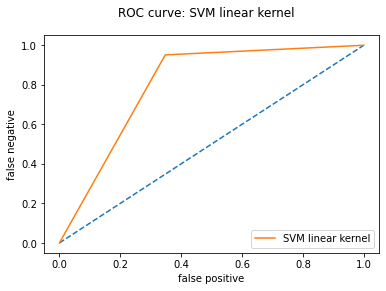

----------------------------------------------
The model  accuracy: 84 %
----------------------------------------------
The training time is:  5ms
----------------------------------------------
The f1 score is : 0.82
----------------------------------------------
The roc_auc_score is : 0.8
----------------------------------------------
The confusion matrix is :



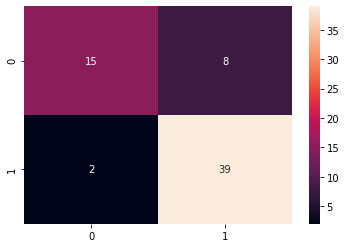

In [80]:
###################################################### Linear kernel ###########################################################
optimal_split_state1 = 0
maxAccuracy = 0
maxF1 = 0

# We already tune parameters, we do not need to loop over all the hyperparamters again, 
# if you want to do so just set max_iteration to 2000 for example 
# and remove the line 'optimal_split_state = 388628375' at the bottom of this cell.

max_iteration = 0
if max_iteration != 0:
    print ('----------------------------------------Hyperparameters tunning starts----------------------------------------\n\n')

for k in range(max_iteration):
    print ('Iteration :'+str(k)+', Current accuracy: '+str(maxAccuracy)+' Current f1 '+str(maxF1), end="\r")
    # Let's get the optimal C value for the linear kernal
    split_state = np.random.randint(1,1000000000)-1
    X_train,X_val,X_test,y_train,y_val,y_test = split(df,rest_size=0.4,test_size=0.4,randomState=split_state)
    optimal_C = optimal_C_value()


    # Now let's use the optimal C value
    linear_clf = SVC(C=optimal_C,kernel='linear')

    # Let's train the model with the optimal C value and calculate the training time
    tic = time()
    linear_clf.fit(X_train, y_train)
    toc = time()
    time1 = str(round(1000*(toc-tic))) + "ms"
    y_linear = linear_clf.predict(X_test)
    linear_f1 = f1_score(y_test, y_linear, average='macro')
    linear_accuracy = accuracy_score(y_test, y_linear)*100
    if linear_accuracy>maxAccuracy and linear_f1>maxF1:
        maxAccuracy = linear_accuracy
        maxF1 = linear_f1
        optimal_split_state1 = split_state
    if maxAccuracy>86 and maxF1>80:
        break;
        
# We've already tuned our hyperparameters, we will not repeat that again as it takes soo long. 
# The optimal split state for linear kernel is 388628375
# Let's try that split state 
optimal_split_state1 = 388628375
X_train,X_val,X_test,y_train,y_val,y_test = split(df,rest_size=0.4,test_size=0.4,randomState=optimal_split_state1)
optimal_C = optimal_C_value()


# Now let's use the optimal C value
linear_clf = SVC(C=optimal_C,kernel='linear')

# Let's train the model with the optimal C value and calculate the training time
tic = time()
linear_clf.fit(X_train, y_train)
toc = time()
time1 = str(round(1000*(toc-tic))) + "ms"
y_linear = linear_clf.predict(X_test)
linear_accuracy = accuracy_score(y_test, y_linear)*100
if max_iteration != 0:
    print('\n\n\n                            ---------------------------process ended'\
         '------------------------------------                            \n\n\n')

# Let's show the resuls
showResults(linear_accuracy, time1, y_linear,'SVM linear kernel')

##### Conclusion
As you can see the metrics show that our linear kernel svm classifier is very effective, an accuracy of 84 % is much acceptable for our problem, the confusion matric is roughly diagonal which indicate that our classifier is able to label your data correctly.

II. Polynomial Kernel :

------------------------------------------------Results : SVM polynomial kernel -------------------------------------------------

 The ROC curve is :



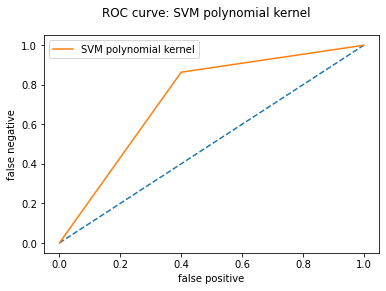

----------------------------------------------
The model  accuracy: 78 %
----------------------------------------------
The training time is:  4ms
----------------------------------------------
The f1 score is : 0.74
----------------------------------------------
The roc_auc_score is : 0.73
----------------------------------------------
The confusion matrix is :



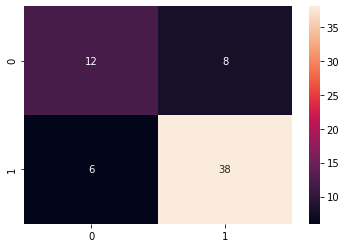

In [81]:
###################################################### Polynomial kernel #######################################################
optimal_split_state2 = 0
maxAccuracy = 0
maxF1 = 0


# We already tune parameters, we do not need to loop over all the hyperparamters again, 
# if you want to do so just set max_iteration to 500 for example 
# and remove the line 'optimal_split_state2 = 7070621' at the bottom of this cell.

max_iteration = 0
if max_iteration != 0:
    print ('----------------------------------------Hyperparameters tunning starts----------------------------------------\n\n')
for k in range(max_iteration):
    print ('Iteration :'+str(k)+', Current accuracy: '+str(maxAccuracy)+', Current f1 '+str(maxF1), end="\r")
    
    split_state = np.random.randint(1,100000000)-1
    X_train,X_val,X_test,y_train,y_val,y_test = split(df,rest_size=0.4,test_size=0.4,randomState=split_state)

    # Let's get the optimal C and the degree value for the polynomial kernal
    optimal_C, optimal_d = optimal_C_d_values()
    
    # Now let's use the optimal c value and the optimal degree value
    poly_clf = SVC(C=optimal_C,kernel='poly', degree=optimal_d)

    # Let's train the model with the optimal C value 
    poly_clf.fit(X_train, y_train)
    y_poly = poly_clf.predict(X_test)
    poly_f1 = f1_score(y_test, y_poly, average='macro')
    poly_accuracy = accuracy_score(y_test, y_poly)*100
    
    if poly_accuracy>maxAccuracy and poly_f1>maxF1:
        maxAccuracy = poly_accuracy
        maxF1 = poly_f1
        optimal_split_state2 = split_state

# We've already tuned our hyperparameters, we will not repeat that again as it takes soo long. 
# The optimal split state for polynomial kernel is 7070621
# Let's try that split state 
optimal_split_state2 = 7070621

X_train,X_val,X_test,y_train,y_val,y_test = split(df,rest_size=0.4,test_size=0.4,randomState=optimal_split_state2)

optimal_C, optimal_d = optimal_C_d_values()


# Now let's use the optimal C value
poly_clf = SVC(C=optimal_C,kernel='poly', degree=optimal_d)

# Let's train the model and calculate the training time
tic = time()
poly_clf.fit(X_train, y_train)
toc = time()
time2 = str(round(1000*(toc-tic))) + "ms"
y_poly = poly_clf.predict(X_test)
poly_accuracy = accuracy_score(y_test, y_poly)*100
if max_iteration != 0:
    print('\n\n\n                            ---------------------------process ended'\
         '------------------------------------                            \n\n\n')

# Let's show the resuls
showResults(poly_accuracy, time2, y_poly,'SVM polynomial kernel')

##### Conclusion
As you can see the metrics show that our polynomial kernel svm classifier is not effective that much, an accuracy of 78 % is not that good for our problem, the confusion matric indicates that our classifier miss labeled some data.

III. Gaussian Kernel :

------------------------------------------------Results : SVM gaussian kernel -------------------------------------------------

 The ROC curve is :



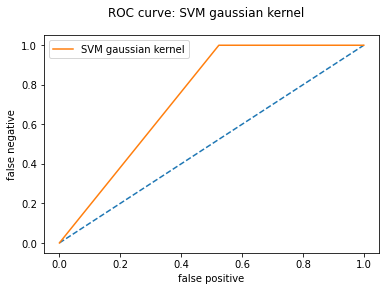

----------------------------------------------
The model  accuracy: 83 %
----------------------------------------------
The training time is:  2ms
----------------------------------------------
The f1 score is : 0.77
----------------------------------------------
The roc_auc_score is : 0.74
----------------------------------------------
The confusion matrix is :



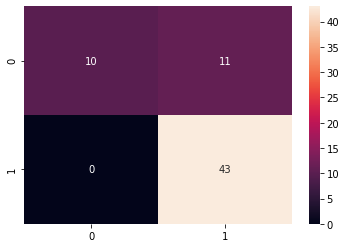

In [82]:
###################################################### Gaussian kernel ######################################################
optimal_split_state3 = 0
maxAccuracy = 0
maxF1 = 0


# We already tune parameters, we do not need to loop over all the hyperparamters again, 
# if you want to do so just set max_iteration to 500 for example 
# and remove the line 'optimal_split_state3 = 93895097' at the bottom of this cell.

max_iteration = 0
if max_iteration != 0:
    print ('----------------------------------------------Hyperparameters tunning starts'\
          '--------------------------------------------\n\n')
for k in range(max_iteration):
    print ('Iteration :'+str(k)+', Current accuracy: '+str(maxAccuracy)+', Current f1 '+str(maxF1), end="\r")
    
    split_state = np.random.randint(1,100000000)-1
    X_train,X_val,X_test,y_train,y_val,y_test = split(df,rest_size=0.4,test_size=0.4,randomState=split_state)

    # Let's get the optimal C and the degree value for the polynomial kernal
    optimal_C, optimal_gamma = optimal_C_gamma_values()
    
    # Now let's use the optimal c value and the optimal degree value
    gauss_clf = SVC(C=optimal_C,kernel='rbf',gamma=optimal_gamma)

    # Let's train the model with the optimal C value 
    gauss_clf.fit(X_train, y_train)
    y_gauss = gauss_clf.predict(X_test)
    gauss_f1 = f1_score(y_test, y_gauss, average='macro')
    gauss_accuracy = accuracy_score(y_test, y_gauss)*100
    
    if gauss_accuracy>maxAccuracy and gauss_f1>maxF1:
        maxAccuracy = gauss_accuracy
        maxF1 = gauss_f1
        optimal_split_state3 = split_state

# We've already tuned our hyperparameters, we will not repeat that again as it takes soo long. 
# The optimal split state for polynomial kernel is 93895097
# Let's try that split state 
optimal_split_state3 = 93895097

X_train,X_val,X_test,y_train,y_val,y_test = split(df,rest_size=0.4,test_size=0.4,randomState=optimal_split_state3)

optimal_C, optimal_gamma = optimal_C_gamma_values()


# Now let's use the optimal C value
gauss_clf = SVC(C=optimal_C,kernel='rbf',gamma=optimal_gamma)

# Let's train the model and calculate the training time
tic = time()
gauss_clf.fit(X_train, y_train)
toc = time()
time3 = str(round(1000*(toc-tic))) + "ms"
y_gauss = gauss_clf.predict(X_test)
gauss_accuracy = (accuracy_score(y_test, y_gauss)*100)

if max_iteration != 0:
    print('\n\n\n                            ---------------------------process ended'\
         '------------------------------------                            \n\n\n')
                                                                
# Let's show the resuls
showResults(gauss_accuracy, time3, y_gauss,'SVM gaussian kernel')

#### Conclusion
As you can see the metrics show that our gaussian kernel svm classifier is not effective comparing to linear kernel classifier, an accuracy of 78 % is not that good for our problem, the confusion matric indicates that this classifier also miss labeled some data.

##### 3) Comparison of the three svm kernels:

------------------------------------------------ Comparison -----------------------------------------------------


     metric      Linear kernel polynomial kernel gaussian kernel
---------------- ------------- ----------------- ---------------
   training time           5ms               4ms             2ms
                                                                
      accuracy %        84.375            78.125         82.8125
                                                                
confusion matrix       [15  8]           [12  8]         [10 11]
                       [ 2 39]           [ 6 38]         [ 0 43]
                                                                
        f1 score          0.82              0.74            0.77
                                                                
   roc_auc_score          0.80              0.73            0.74



The Roc curves :



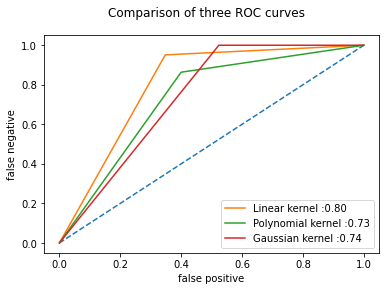

In [84]:
compare_kernels()

Conclusion :
As you can see the best svm kernel model is the one that used the linear kernel, it performed very well on the test set as it has high accuracy as well as high f1 score.

If you see the Roc curve, you will notice that the orange curve is way above the blue dashed curve, this is why we got a high ROC score with a value of 0.8 which is the value of the surface under the orange curve.

We will choose the linear kernel.

###### 4) The most accurate svm kernel is the linear kernel:

The choosen kernel : linear kernel
the training : 5ms
the accuracy : 84 %
the f1 score : 0.82
The roc_auc_score is : 0.8
----------------------------------------
The ROC curve :


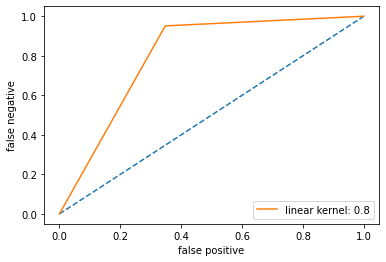

----------------------------------------
The confusion matrix is  :


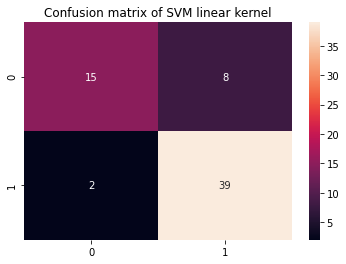

In [86]:
yt_svm,yp_svm = best_kernel('linear kernel')

#### 5) Factors affecting performances of studens using SVM classifer :

In [87]:
# Get svm parameters
coefs = linear_clf.coef_

# factors helping students to succeed
column_to_string(factors(coefs, 5, 'max', df),'max')

# factors leading students to failure
column_to_string(factors(coefs, 5, 'min', df), 'min')

-----------------------------------------------------------------------------------
Factors helping students succeed :
father's education
guardian
wants to take higher education
studytime
father's job
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
Factors leading students to failure
age
health
going out with friends
absences
failures


### Comparison of the three algorithms

In [88]:
# Function to compare the three classifiers (Logistic regression, KNN and SVM) performances :

def compare_lg_knn_svm(yt_knn,yp_knn,yt_lg,yp_lg,yt_svm,yp_svm):
    #F1 score
    f1_lg = round(f1_score(yt_lg, yp_lg, average='macro')*100)
    f1_knn = round(f1_score(yt_knn, yp_knn, average='macro')*100)
    f1_svm = round(f1_score(yt_svm, yp_svm, average='macro')*100)
    
    #Accuracy score
    acc_lg = round(accuracy_score(yt_lg, yp_lg)*100)
    acc_knn = round(accuracy_score(yt_knn, yp_knn)*100)
    acc_svm = round(accuracy_score(yt_svm, yp_svm)*100)
    
    #Confusion matrix
    conf_lg = confusion_matrix(yt_lg, yp_lg)
    conf_knn = confusion_matrix(yt_knn, yp_knn)
    conf_svm = confusion_matrix(yt_svm, yp_svm)
    
    #ROC score
    roc_c_lg = round(roc_auc_score(yt_lg, yp_lg)*100)
    roc_c_knn = round(roc_auc_score(yt_knn, yp_knn)*100)
    roc_c_svm = round(roc_auc_score(yt_svm, yp_svm)*100)
    
    #ROC curve thresholds
    roc_knn = roc_curve(yt_knn,yp_knn)
    roc_lg = roc_curve(yt_lg,yp_lg)
    roc_svm = roc_curve(yt_svm,yp_svm)
    
    # Table of metrics
    print('-----------------------------Table of metrics--------------------------------------\n\n')
    data_rows = [('f1 score',f1_lg,f1_knn,f1_svm),
                 ('','','',''),
                  ('accuracy %',acc_lg,acc_knn,acc_svm),
                 ('','','',''),
                 ('confusion matrix',conf_lg[0], conf_knn[0], conf_svm[0]),
                ('',conf_lg[1], conf_knn[1], conf_svm[1]),
                 ('','','',''),
                ('ROC score',roc_c_lg,roc_c_knn,roc_c_svm)]
    t = Table(rows=data_rows, names=('metric','Logistic regression', 'KNN', 'SVM'))
    print(t)
    
    #Plot ROC curve
    print('\n\n-----------------------------ROC curves--------------------------------------\n\n')
    fig, _ = plt.subplots()
    fig.suptitle('Comparison of three ROC curves')
    fpr,tpr,thresholds=roc_lg
    plt.plot([0, 1],[0, 1],'--')
    plt.plot(fpr,tpr,label='Logistic regression :'+str(roc_c_lg))
    plt.xlabel('false positive')
    plt.ylabel('false negative')
    fpr,tpr,thresholds=roc_knn
    plt.plot(fpr,tpr,label='KNN :'+str(roc_c_knn))
    fpr,tpr,thresholds=roc_svm
    plt.plot(fpr,tpr,label='SVM :'+str(roc_c_svm))
    plt.legend()
    plt.show()
    
    
    # Maximum metrics
    print('-----------------------------Max of metrics--------------------------------------\n\n')
    data_rows = [('max f1 score',algo_with_max_metric(f1_lg,f1_knn,f1_svm)),
                 ('','','',''),
                  ('max accuracy %',algo_with_max_metric(acc_lg,acc_knn,acc_svm)),
                 ('','','',''),
                ('max ROC score',algo_with_max_metric(roc_c_lg,roc_c_knn,roc_c_svm))]
    t = Table(rows=data_rows, names=('metric','Learning algorithm winnig'))
    print(t)
    
# Function returning name of winnig algorithm based on a single metric
def algo_with_max_metric(a,b,c):
    max_metric = max(a,b,c)
    if max_metric == a:
        return 'Logistic regression'
    elif max_metric == b:
        return 'KNN'
    else:
        return 'SVM'

-----------------------------Table of metrics--------------------------------------


     metric      Logistic regression   KNN     SVM  
---------------- ------------------- ------- -------
        f1 score                  74      54      82
                                                    
      accuracy %                  81      80      84
                                                    
confusion matrix             [18 17] [ 3 23] [15  8]
                             [ 6 78] [ 1 92] [ 2 39]
                                                    
       ROC score                  72      55      80


-----------------------------ROC curves--------------------------------------




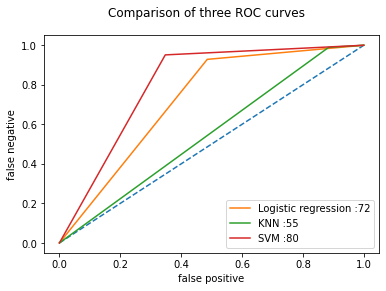

-----------------------------Max of metrics--------------------------------------


    metric     Learning algorithm winnig
-------------- -------------------------
  max f1 score                       SVM
                                        
max accuracy %                       SVM
                                        
 max ROC score                       SVM


In [89]:
compare_lg_knn_svm(yt_knn,yp_knn,yt_lg,yp_lg,yt_svm,yp_svm)

##### Conclusion of selected classifier for our problem :
As you can see the classifier with high metrics is the support vector machine classifier with high accuracy of 84%, the confusion matrix is roughly diagonal which indicate that this classifier is able to label data correctly. If we see other metrics such as f1 score, we managed to have a good value of 0.82 which means that we have low false positives and low false negatives.